In [1]:
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
import datetime
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations
from scipy.stats import qmc
import Tasmanian
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

import bo_methods_lib
from bo_methods_lib.bo_functions_generic import eval_GP_sparse_grid, LHS_Design, normalize_bounds, gen_theta_set, find_train_doc_path, test_train_split, clean_1D_arrays, norm_unnorm, get_sparse_grids, calc_ei_basic, calc_ei_emulator
from bo_methods_lib.normalize import normalize_p_data, normalize_x, normalize_p_true, normalize_p_bounds
from bo_methods_lib.CS2_create_data import *
from bo_methods_lib.CS2_bo_functions_multi_dim import argmax_multiple
# from bo_methods_lib.CS1_create_data import *
# from bo_methods_lib.test_CS1_create_data import *
import itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations
from sklearn.preprocessing import MinMaxScaler
import random

# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
train1 = np.array([[0, 1,2,3],[0, 1,2,3]])
train2 = np.array([[0, 1,2,3,4],[0, 1,2,3,4]])
print(train1[:,1:-1])
print(train2[:,1:-1])
print(train1[:,1:2+1])
print(train2[:,1:2+1+1])

[[1 2]
 [1 2]]
[[1 2 3]
 [1 2 3]]
[[1 2]
 [1 2]]
[[1 2 3]
 [1 2 3]]


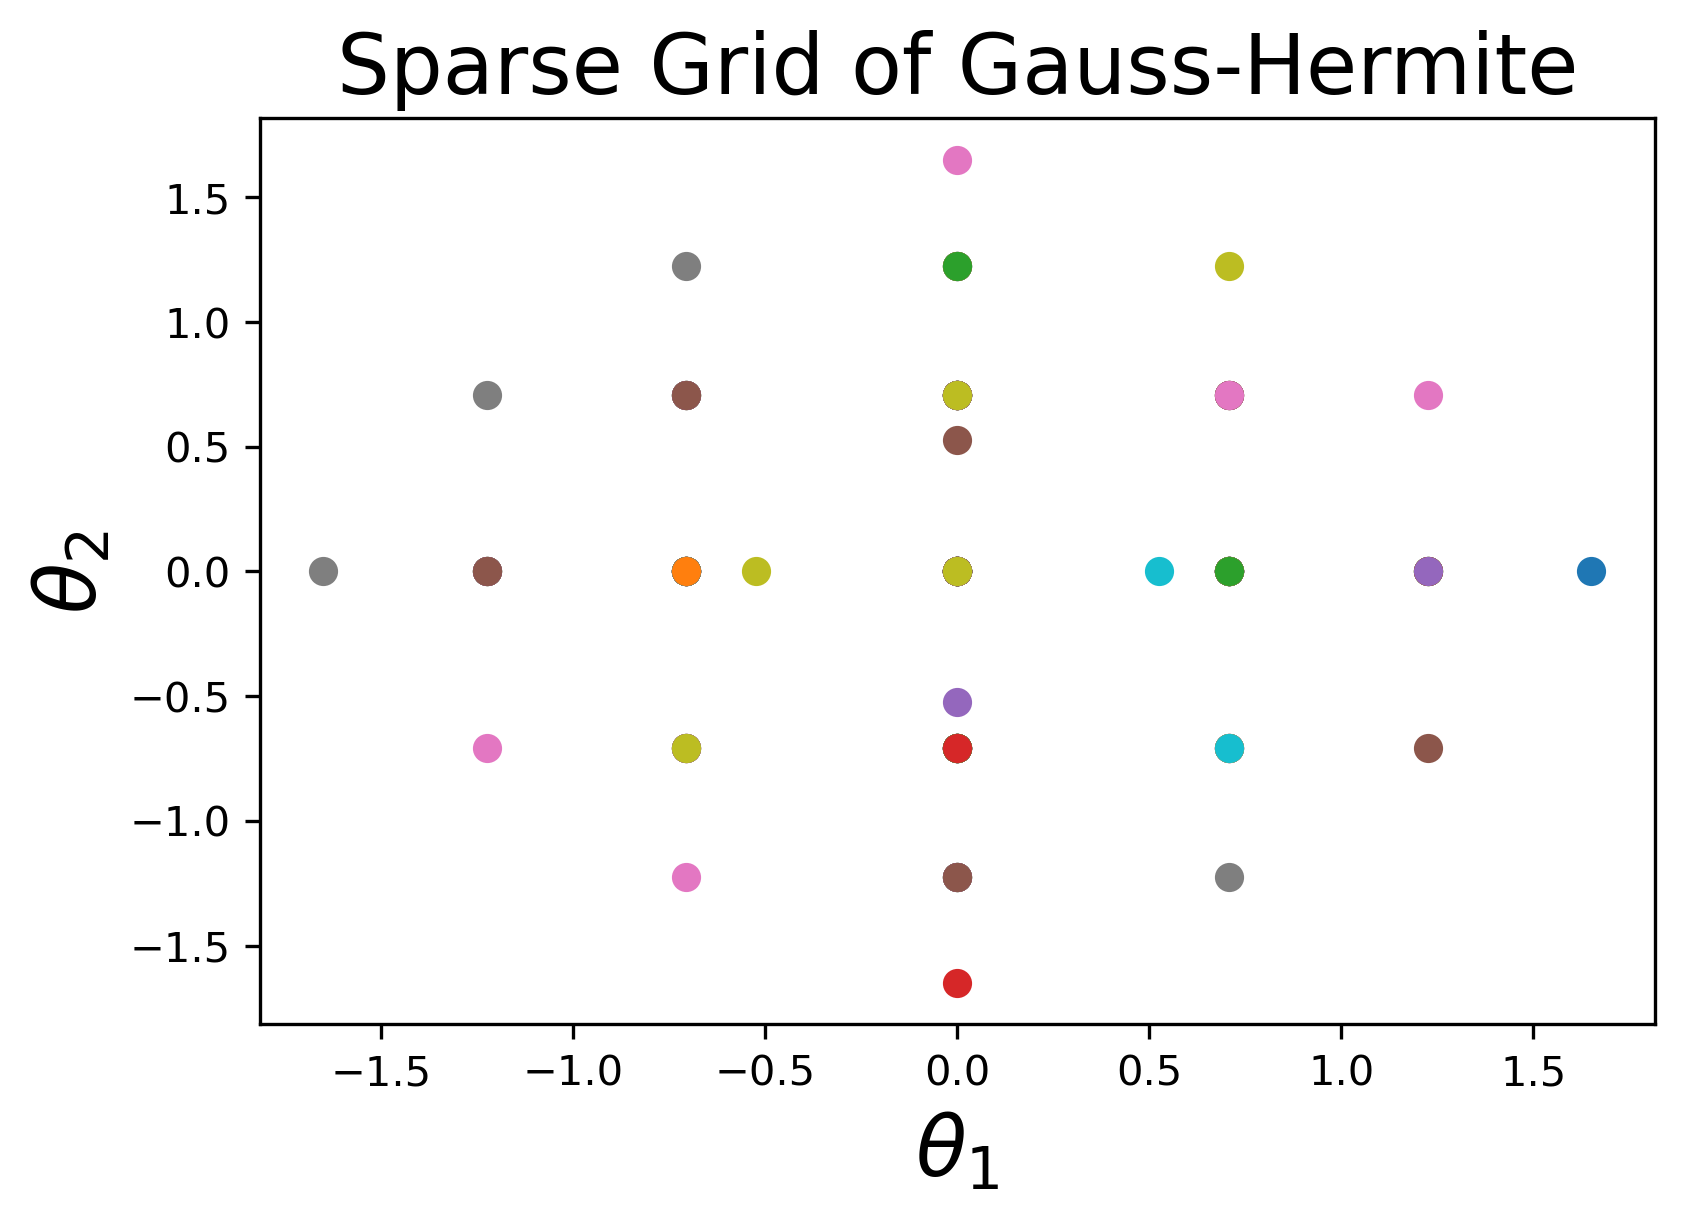

Assuming n = 5 dimensions and a cost limit of 1000 weights, a depth of 3 should be used.


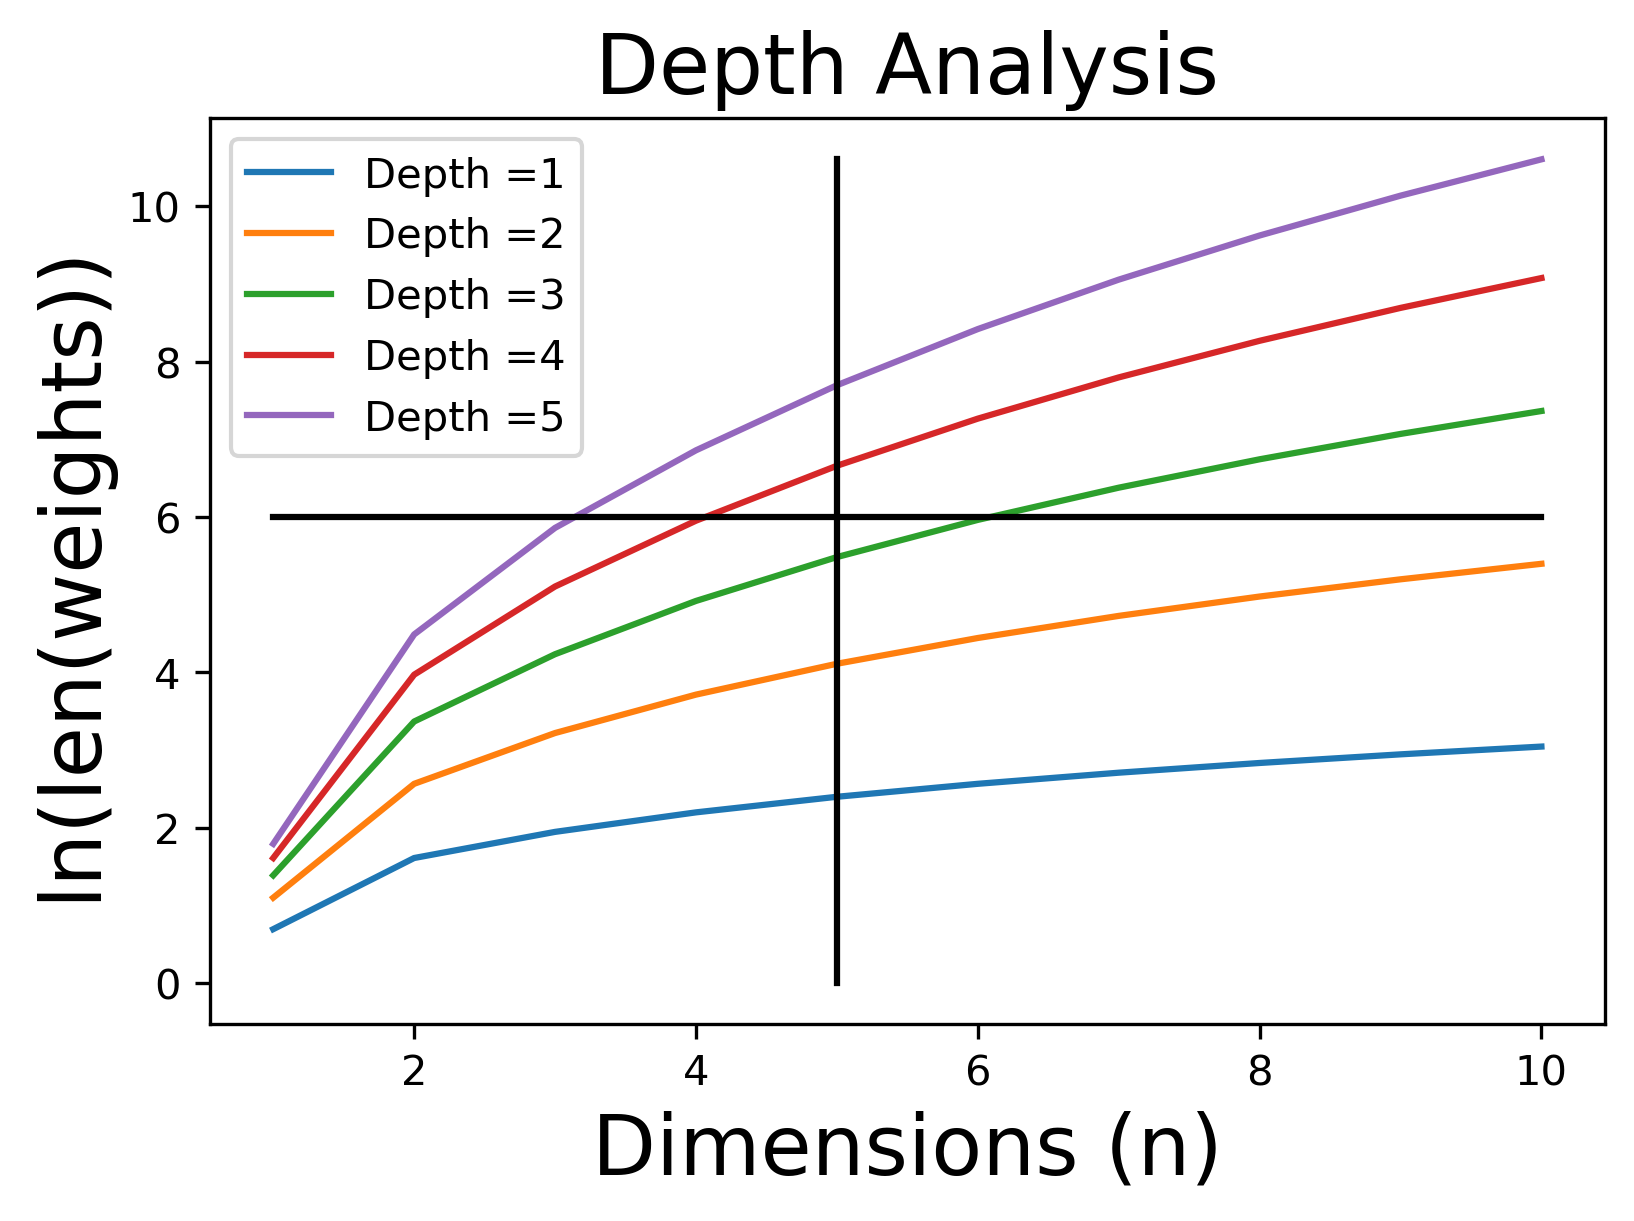

In [3]:
n = 5
get_sparse_grids(n,output=0,depth=3, rule='gauss-hermite', verbose = True)

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/n=5.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1]
n_exp = len(Xexp) 
n = 10
max_cost = 1000
n_space = np.linspace(1,n,n)

plt.figure()
plt.xlabel("Dimensions (n)", fontsize = 20)
plt.ylabel("ln(len(weights))", fontsize = 20)
plt.title("Depth Analysis", fontsize = 20)
plt.grid(False)

depth = np.array([1,2,3,4,5])

log_ln_weights_at_n = []

for i in depth:
    log_len_weights = np.zeros(n)  
    for j in n_space:
        weights = get_sparse_grids(int(j), output=0, depth = int(i))[1]   
        log_len_weights[int(j-1)] = np.log(len(weights))
    weight_at_n = get_sparse_grids(int(n_exp), output=0, depth = int(i))[1] 
    log_ln_weights_at_n.append(np.log(len(weight_at_n)))
    plt.plot(n_space,log_len_weights, label = "Depth ="+str(i))
plt.plot(n_space, np.full(n, np.log(max_cost), dtype=int), color = "black")
plt.plot([n_exp,n_exp], [0,np.amax(log_len_weights)], color = "black")
plt.legend(loc = "best")   

index_max_depth = max(loc for loc, val in enumerate(log_ln_weights_at_n) if val <= np.log(max_cost)) - 1
max_depth = depth[index_max_depth]
print("Assuming n =", n_exp, "dimensions and a cost limit of", max_cost, "weights, a depth of",max_depth,"should be used.")

In [5]:
l = np.array([1,2,3])
listy = [l,l,l]
new_list = []
for i in range(2):
    new_list.append(listy)
print(new_list[0])

[array([1, 2, 3]), array([1, 2, 3]), array([1, 2, 3])]


In [ ]:
from bo_methods_lib.GP_Vs_True_Sensitivity import Muller_plotter_all
test_mesh = np.load("2023/03/17/16-30/CSV_Data/GP_Vs_Sim_Comp_CB/CS_2.2/len_scl_varies/TP_1000/X_space_unmeshed.npy")
test_mesh = test_mesh.reshape((20,20,2)).T
GP_mean = np.load("2023/03/17/16-30/CSV_Data/GP_Vs_Sim_Comp_CB/CS_2.2/len_scl_varies/TP_1000/GP_mean/a_1_pct_00/Mul_Pot.npy")
GP_stdev = np.load("2023/03/17/16-30/CSV_Data/GP_Vs_Sim_Comp_CB/CS_2.2/len_scl_varies/TP_1000/GP_stdev/a_1_pct_00/Mul_Pot.npy")
Sim_val = np.load("2023/03/17/16-30/CSV_Data/GP_Vs_Sim_Comp_CB/CS_2.2/len_scl_varies/TP_1000/Sim_val/a_1_pct_00/Mul_Pot.npy")
X_t = np.load("2023/03/17/16-30/CSV_Data/GP_Vs_Sim_Comp_CB/CS_2.2/len_scl_varies/TP_1000/Sim_val/a_1_pct_00/X_train.npy")
t = 1000
Case_Study = 2.2
CutBounds = True
DateTime = "2023/03/17/16-30"

minima = np.array([[-0.558,1.442],
                              [-0.050,0.467],
                              [0.623,0.028]])

saddle = np.array([[-0.82,0.62],
              [0.22,0.30]])

set_lengthscale = None
title = ["Y sim", "GP mean", "GP stdev"]
z = [Sim_val, GP_mean, GP_stdev]

Mul_title = ["/Sim_val", "/GP_mean", "/GP_stdev"]
param = "a1"
percentile = "00"
Muller_plotter_all(test_mesh, z, minima, saddle, title, set_lengthscale, t, Case_Study, CutBounds, 
               DateTime = None, X_train = X_t, save_csvs = True, save_figure = True, Mul_title = Mul_title, param = param, 
               percentile = percentile)

In [ ]:
percentiles = np.linspace(0,0,1)
print(len(percentiles))

In [ ]:
bounds_p = np.array([[-2, -2, -10, -2, -2, -2,  5, -2],
                   [ 2,  2,   0,  2,  2,  2, 15,  2]])

upper = bounds_p[1,0]
lower = bounds_p[0,0]
print((upper - lower)*0.1)

percentiles = np.linspace(-1.0,1.0,41)
percentiles_numbered = np.linspace(0,len(percentiles)-1, len(percentiles))
print(len(percentiles), len(percentiles_numbered))

for i in range(len(percentiles)):
    F = str(int(percentiles_numbered[i])).zfill(len(str(10)))
    print(F)

In [ ]:
data = np.array([[0.99477801, -1.004316476, 1, -1],
                [0.994121900, -1.003294954, 1 ,-1],
                [0.994804279, -1.001754676, 1, -1],
                [0.995009548, -1.002353734, 1, -1],
                [0.995020159, -0.999697620, 1, -1]])
df_plot = pd.DataFrame(data=data, columns=["Theta 1", "Theta 2", "True Theta 1", "True Theta 2" ])
Del_Theta_1 = df_plot['Theta 1'].values - df_plot['True Theta 1'].values
Del_Theta_2 = df_plot['Theta 2'].values - df_plot['True Theta 2'].values
Theta_Diff_Matrix = np.array([Del_Theta_1, Del_Theta_2])
#         print(Theta_Diff_Matrix.shape)
#Am I doing this right?
df_theta_norm = np.zeros(Theta_Diff_Matrix.shape[1])
for i in range(Theta_Diff_Matrix.shape[1]):
    df_theta_norm[i] = np.linalg.norm(Theta_Diff_Matrix[:,i], ord = 2)
print(df_theta_norm)

In [ ]:
# param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4',
#               4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}

# print(list(param_dict.values()))

# Create an empty DataFrame with columns 'A', 'B', and 'C'
df = pd.DataFrame(columns=['A', 'B', 'C'])

# Define the number of rows to append to the DataFrame
num_rows = 5
Ihateyou = []
# Loop through and append tensors to the DataFrame
for i in range(num_rows):
    # Create a PyTorch tensor to append to the DataFrame
    new_row = torch.Tensor([i, i+1, i+2])
    Ihateyou.append(new_row.numpy())
print(Ihateyou)
df = pd.DataFrame(Ihateyou, columns=['A', 'B', 'C'])

print(df)

In [ ]:
import numpy as np

n=3
# Sample array
arr = np.array([[1, 2], [3, 4], [5, 6], [1, 2], [3, 4], [5, 6], [1, 2], [3, 4], [5, 6]])

group = np.zeros(len(arr))
for i in range(len(arr)):
    if i == 0:
        group[i] = 1
    elif i%n == 0 and i > 0:
        group[i] = group[i-1] + 1
    else:
        group[i] = group[i-1]

# Print the result
print(group)

In [ ]:
#Meshgrid to combinations
p=20
# x_space = gen_theta_set(LHS = False, n_points = p, dimensions = 2, bounds = bounds_x)
x_space = test_mesh
# print(x_space.reshape(p,p,-1).T)

X1 =  np.linspace(-1.5,1,p) #1x10
X2 =  np.linspace(-0.5,2,p) #1x10
X_mesh = np.array(np.meshgrid(X1, X2)) #2 Uniform 5x5 arrays
print(X_mesh.shape)

Test1 = np.zeros((X_mesh.shape[1:3]))
for i in range(X_mesh.shape[1]):
    #Loop over X2
    for j in range(X_mesh.shape[2]):
        Test1[i,j] = X_mesh[0,i,j] + X_mesh[1,i,j]

print(Test1.shape)

Test2 = []
for k in range(len(x_space)):
    Test2.append(x_space[k,0] + x_space[k,1])
Test2 = np.array(Test2).reshape((p, p))

# print(Test2)

In [ ]:
EI_max = np.load("2022/10/21/13-18/CSV_Data/Convergence_Figs/GP_Emulator/Approx/TP_100/obj/ep_0.8/len_scl_varies/Sep_Fact_1.0/Total_Runs_15/Max_EI_Conv.npy")
EI_max = np.load("2022/10/21/13-18/CSV_Data/Convergence_Figs/GP_Error_Emulator/TP_20/obj/ep_0.3/len_scl_varies/Sep_Fact_1.0/Total_Runs_15/Max_EI_Conv.npy")
print(np.max(EI_max[:,99]))

In [ ]:
CS = 1

Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])
if CS == 2.2:
    skip_param_types = 1 #This is what changes for subpoint
    Theta_True = Constants[skip_param_types:skip_param_types+2].flatten()
    param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4',
                  4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}
    exp_d = 2
    n = 15 #Number of experimental data points to use
    bounds_p = np.array([[-2, -2, -10, -2, -2, -2,  5, -2],
                       [ 2,  2,   0,  2,  2,  2, 15,  2]])
    bounds_x = np.array([[-1.5,-0.5],[1,2]])
    LHS = True

else:
    Constants = Theta_True = np.array([1,-1])
    skip_param_types = 0
    param_dict = {0 : '\\theta_1', 1 : '\\theta_2'}
    exp_d = 1
    bounds_x = np.array([[-2],[2]])
    bounds_p = np.array([[-2,-2],
                     [2 , 2]])
    LHS = False
    n = 5

print(Constants.shape)
print(Theta_True.shape)

p = 20
d = len(Theta_True)

obj = np.array(["obj, LN_obj"])
emulator = np.array([True, False])

# if emulator == True:
#     t = 20*n
# else:
#     t = 20

# #Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d='+str(exp_d)+'/n='+str(n)+'.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1:exp_d+1]
Yexp = exp_data[:,-1]
Xexp = clean_1D_arrays(Xexp)

m = Xexp.shape[1]
print(Xexp.shape)

theta_mesh = gen_theta_set(LHS = LHS, n_points = p, dimensions = d, bounds = bounds_p)
print(theta_mesh.shape)
theta_set = theta_mesh

# all_data_doc = find_train_doc_path(emulator, obj, d, t)
# all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 
# print(all_data.shape)

# train_data, test_data = test_train_split(all_data, sep_fact = 1.0, shuffle_seed=9)

# if CS == 1 and emulator == False:
#     train_p, test_p = train_data[:,1:-2], test_data[:,1:-2]
# else:
#     train_p, test_p = train_data[:,1:-1], test_data[:,1:-1]
# print(train_p)
print(train_p.shape)
print(test_p.shape)

In [ ]:
DataFrame.to_csv(

In [ ]:
argmax= np.array([0,1,2,3])
train_p = np.array([[-1.5, -1.5], [-1.6, -1.6], [-1.7, -1.7], [-1.8, -1.8]])
theta_set = np.array([[1.5, 1.5], [1.6, 1.6], [1.7, 1.7], [1.8, 1.8]])
print(argmax_multiple(argmax, train_p, theta_set))

In [ ]:
#Calculating actual SSE Values
norm = True
bounds_x_scl, scaler_x = normalize_x(bounds_x, None, norm, scaler = None)
bounds_p_scl, scaler_theta = normalize_p_bounds(bounds_p, norm)
Xexp_scl = normalize_x(Xexp, None, norm, scaler = scaler_x)[0]
print(Xexp_scl)
Xexxp = Xexp_scl[0]
print(Xexp[0])
print(normalize_x(clean_1D_arrays(Xexxp, param_clean = True), None, False, scaler_x))

Guess_0 = np.array([0.61032438,0.43428296,0.72599213,0.66055616,0.52820981,0.95271155,0.94534902,0.87020441])
Guess_0 = normalize_p_true(Guess_0, scaler_theta, norm = False)
Guess_1 = np.array([0,1,0.370735521, 9.23236422E-04,0.166088842, 0.169900862,1,0.024381367])
Guess_1 = normalize_p_true(Guess_1, scaler_theta, norm = False)
Guess_2 = Theta_True



SSE_guess_0 = create_sse_data(Guess_0, Xexp, Yexp, Constants, obj = "obj", skip_param_types = 1)
# GP_guess_0 = 1236476096410.422
GP_guess_0 = 74323.09891172957
SSE_guess_1 = create_sse_data(Guess_1, Xexp, Yexp, Constants, obj = "obj", skip_param_types = 1)
GP_guess_1 =-945327999181.6357
SSE_guess_2 = create_sse_data(Guess_2, Xexp, Yexp, Constants, obj = "obj", skip_param_types = 1)
print(Guess_0, Guess_1)
print("True Params \n", Theta_True)
print("True SSE \n", float(SSE_guess_2))
print("Guess 1 \n", np.round(Guess_0,3))
print("True SSE Guess 1 \n", float(SSE_guess_0), "\n GP Guess 1 \n", GP_guess_0, "\n difference %", abs((GP_guess_0 - float(SSE_guess_0))/float(SSE_guess_0)))
# print("Guess 2 \n", np.round(Guess_1,3))
# print("True SSE Guess 2 \n", float(SSE_guess_1), "\n GP Guess 2 \n", GP_guess_1, "\n difference %", abs((GP_guess_1 - float(SSE_guess_1))/float(SSE_guess_1)))
# print(SSE_guess_2, GP_guess_2)

In [ ]:
# https://realpython.com/python-timer/
import time
start = 3678393
res = datetime.timedelta(seconds =start)
print(res)

time_tot = 0
x = 0
for i in range(89900):
    start2 = time.time()
    x += 1+2
    end = time.time()

    time_tot+= (end - start2)


print(time_tot)